In [1]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage
import google.generativeai as genai
import json
import os
from dotenv import load_dotenv


In [2]:
class EmailState(TypedDict):
    messages: List[HumanMessage]
    draft: str
    approved: bool
    feedback: str

In [3]:

def initialize_gemini():
    """Initialize Gemini with API key"""
    load_dotenv()
    api_key = os.getenv("API_KEY")

    genai.configure(api_key=api_key)

    model = genai.GenerativeModel('gemini-2.0-flash')
    return model


In [4]:
gemini_model = initialize_gemini()

In [5]:
def gemini_invoke(prompt: str) -> str:
    """Invoke Gemini model and return response text"""
    try:
        response = gemini_model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error calling Gemini: {e}")
        return "I apologize, but I encountered an error generating a response."


In [6]:
def input_node(state: EmailState) -> EmailState:
    print(" Input Node: Getting email content...")
    email_text = input("Enter the email you want to reply to:\n> ")
    state["messages"] = [HumanMessage(content=email_text)]
    state["draft"] = ""
    state["approved"] = False
    state["feedback"] = ""
    return state

In [7]:
def llm_node(state: EmailState) -> EmailState:
    print("LLM Node: Generating draft response with Gemini...")
    email_content = state['messages'][0].content

    prompt = f"""
    Write a professional and polite email reply to the following email.
    Keep the response concise yet comprehensive.

    Original email: {email_content}

    Please provide only the email response text without any additional explanations or markdown formatting.
    """

    response = gemini_invoke(prompt)
    state["draft"] = response
    print(f"\nDraft Email:\n{state['draft']}\n")
    return state

In [8]:
def tool_node(state: EmailState) -> EmailState:
    print("Tool Node: Checking grammar and tone...")

    
    text = state.get("draft", "")
    if not text:
        print("No text found in state.")
        return state

    # check and improve grammar and tone
    prompt = f"Review and correct the grammar and tone of this email:\n\n{text}\n\nReturn only the corrected version."
    response = gemini_model.generate_content(prompt)

    corrected_text = response.text.strip() if response.text else text
    state["corrected_draft"] = corrected_text

    print("Tool feedback complete ")
    return state


In [9]:
def conditional_node(state: EmailState) -> str:
    print("Conditional Node: Evaluating quality...")

    draft = state.get("corrected_draft") or state.get("draft", "")
    if not draft.strip():
        print("No draft text found → retrying LLM")
        return "retry_llm"

    # score the draft quality
    prompt = f"""
    You are an expert writing evaluator.
    Evaluate the following email draft for overall quality on a scale of 1 to 10,
    considering clarity, tone, professionalism, and grammar.
    Only return the numeric score and a short comment.

    Email Draft:
    \"\"\"{draft}\"\"\"
    """

    response = gemini_model.generate_content(prompt)
    feedback = response.text.strip() if response.text else "5 - Unable to evaluate"

    print(f"Gemini feedback: {feedback}")

    
    import re
    match = re.search(r"\b([1-9]|10)\b", feedback)
    score = int(match.group(1)) if match else 5

    
    if score < 6:
        print(f"Condition: Low quality (score {score}) → retrying LLM")
        return "retry_llm"
    else:
        print(f"Condition: Good quality (score {score}) → proceed to Memory")
        return "save_memory"

In [10]:
def memory_node(state: EmailState) -> EmailState:
    print("Memory Node: Saving current draft and state...")
    
    
    memory_data = {
        "email": state["messages"][0].content,
        "draft": state["draft"],
        "approved": state["approved"],
        "feedback": state["feedback"]
    }
    
    
    existing_data = []
    if os.path.exists("email_memory.json"):
        with open("email_memory.json", "r") as f:
            existing_data = json.load(f)
        
        
        if isinstance(existing_data, dict):
            existing_data = [existing_data]
    
    
    existing_data.append(memory_data)
    
    
    with open("email_memory.json", "w") as f:
        json.dump(existing_data, f, indent=2)
    
    print(f"State saved to email_memory.json (Total entries: {len(existing_data)})")
    return state

In [11]:
def human_approval_node(state: EmailState) -> EmailState:
    print("human_approval Node: Awaiting human approval...")
    print(f"\nAI Draft:\n{state['draft']}\n")
    choice = input("Do you approve this draft? (yes/no/edit): ").strip().lower()

    if choice == "yes":
        state["approved"] = True
        state["next_step"] = "approved"  
        print(" Approved by human.")
        
    elif choice == "edit":
        new_text = input("Enter your edits:\n> ")
        state["draft"] = new_text
        state["approved"] = True
        state["feedback"] = "Edited manually by human."
        state["next_step"] = "approved"  
        
    else:
        state["feedback"] = "Rejected - needs revision"
        state["next_step"] = "retry_llm"  
        print(" Rejected, returning to LLM.")
    
    return state  

In [12]:
def ui_output_node(state: EmailState) -> EmailState:
    print("\n Final Email Response:\n")
    print("=" * 50)
    print(state["draft"])
    print("=" * 50)
    print("\n Workflow complete.")
    return state


In [13]:
graph = StateGraph(EmailState)


graph.add_node("Input", input_node)
graph.add_node("LLM", llm_node)
graph.add_node("Tool", tool_node)
graph.add_node("Memory", memory_node)
graph.add_node("human_approval", human_approval_node)
graph.add_node("UI", ui_output_node)


graph.add_edge(START, "Input")
graph.add_edge("Input", "LLM")
graph.add_edge("LLM", "Tool")


graph.add_conditional_edges(
    "Tool",  
    conditional_node,  
    {
        "retry_llm": "LLM",
        "save_memory": "Memory",
    },
)


graph.add_edge("Memory", "human_approval")


graph.add_conditional_edges(
    "human_approval",
    lambda state: state.get("next_step", "retry_llm"),  # Read from state
    {
        "approved": "UI",
        "retry_llm": "LLM"
    },
)

graph.add_edge("UI", END)

app = graph.compile()

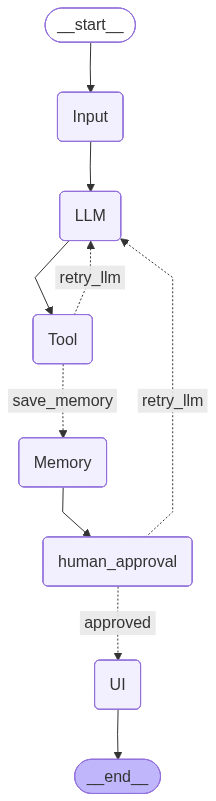

In [14]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
state = {"messages": [], "draft": "", "approved": False, "feedback": ""}
app.invoke(state)

 Input Node: Getting email content...


Enter the email you want to reply to:
>  Hi  Mintesinot,  We came across your GitHub profile while looking for backend software developers and wanted to check if you’re open to new opportunities. If so, we’d be happy to share more details.  Best regards, Mihiret M. Brain³


LLM Node: Generating draft response with Gemini...

Draft Email:
Hi Mihiret,

Thank you for reaching out. I appreciate you considering me for backend developer opportunities.

Yes, I am open to exploring new opportunities. I would be happy to hear more details about the role and your company.

Best regards,

Mintesinot


Tool Node: Checking grammar and tone...
Tool feedback complete 
Conditional Node: Evaluating quality...
Gemini feedback: 8

The email is clear, concise, and professional. The tone is polite and receptive. Minor improvements could include a slightly more enthusiastic closing.
Condition: Good quality (score 8) → proceed to Memory
Memory Node: Saving current draft and state...
State saved to email_memory.json (Total entries: 1)
human_approval Node: Awaiting human approval...

AI Draft:
Hi Mihiret,

Thank you for reaching out. I appreciate you considering me for backend developer opportunities.

Yes, I am open to exploring new opportunities. I would be happy to hear more d

Do you approve this draft? (yes/no/edit):  yes


 Approved by human.

 Final Email Response:

Hi Mihiret,

Thank you for reaching out. I appreciate you considering me for backend developer opportunities.

Yes, I am open to exploring new opportunities. I would be happy to hear more details about the role and your company.

Best regards,

Mintesinot


 Workflow complete.


{'messages': [HumanMessage(content='Hi  Mintesinot,  We came across your GitHub profile while looking for backend software developers and wanted to check if you’re open to new opportunities. If so, we’d be happy to share more details.  Best regards, Mihiret M. Brain³', additional_kwargs={}, response_metadata={})],
 'draft': 'Hi Mihiret,\n\nThank you for reaching out. I appreciate you considering me for backend developer opportunities.\n\nYes, I am open to exploring new opportunities. I would be happy to hear more details about the role and your company.\n\nBest regards,\n\nMintesinot\n',
 'approved': True,
 'feedback': ''}

 Approved by human.

 Final Email Response:

Hi Mihiret,

Thank you for reaching out. I appreciate you considering me for backend software developer opportunities.

Yes, I am open to exploring new opportunities. I would be happy to learn more about the role and your company, Brain³.

Best regards,
Mintesinot


 Workflow complete.


{'messages': [HumanMessage(content='Hi  Mintesinot,  We came across your GitHub profile while looking for backend software developers and wanted to check if you’re open to new opportunities. If so, we’d be happy to share more details.  Best regards, Mihiret M. Brain³', additional_kwargs={}, response_metadata={})],
 'draft': 'Hi Mihiret,\n\nThank you for reaching out. I appreciate you considering me for backend software developer opportunities.\n\nYes, I am open to exploring new opportunities. I would be happy to learn more about the role and your company, Brain³.\n\nBest regards,\nMintesinot\n',
 'approved': True,
 'feedback': ''}